### Project Introduction

In this project, I will attempt to build a machine learning model that can classify chest x-ray images images based on three categories. 

- Normal
- Covid-19
- Viral Pneumonia 


###   About the Dataset   

The COVID-19 Radiography Database, available on Kaggle, is a dataset designed for medical image analysis, particularly for detection of COVID-19 through chest r-xay imaging. Following are some key aspects of this dataset: 

####  Dataset overview
    - Images:The dataset contains x-ray images of patients with COVID-19, viral pneumonia, lung opacity, and healthy individuals. 
    
    - Classes:There are four main classes, COVID-19 positive cases, viral pneumonia cases, lung opacity (other types of lung infections), normal (healthy) x-ray images. 
    
    - Data Structure:The image files are stored in respective folders for each category. Each folder contains x-ray images in .png format. 
    
    - Image count:The dataset contains thousands of images, offering a substantial number for training a prediction model. 

All the images are in Portable Network Graphics (PNG) file format with the resolution of 299x299 pixels. The dataset currently holds 3,616 COVID-19 positive cxr images, 10,192 Normal cxr images and 1,345 Viral Pneumonia cxr images.

###  Acknowledgements

The database creators recognize the contributions of various institutions and researchers who made the data collection possible. Please refer [here](https://www.kaggle.com/code/jnegrini/covid-19-radiography-data-eda-and-cnn-model) for a complete list of collaborators and more details on the dataset. 

###  Importing Necessary Packages

Before proceeding to work with the data, I will first import all necessary Python packages.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow.keras import layers, models
import keras
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import MaxPool2D, Conv2D
from keras.layers import Activation, BatchNormalization, Dropout, Flatten, Dense
from keras.models import Sequential, Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

### Loading the Image Data

The COVID-19 Radiography database is very large, so I will now load the image paths just for covid positive cxr's, normal cxr's and pneumonia cxr's. 

In [2]:
import os
import cv2
from tqdm import tqdm

# Image paths
imagePaths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    # Only processing files inside the 'images' folder
    if 'images' in dirname:
        for filename in filenames:
            if filename.endswith('png'): 
                imagePaths.append(os.path.join(dirname, filename))

###  Pre-processing before image processing

Before working with cxr images and training the model, I will pre-process the data by resizing each image size to a  consistent size of 150x150 pixels and normalizing pixel values to the range [0, 1] for uniformity. I will extract labels from the folder structure, mapped to simplified classes ('Pneumonia', 'Normal', 'Covid-19) and will keep only relevant images. This step will ensure that the cxr images are ready for further analysis and model training. 

In [3]:
# Initial list for images and their corresponding labels
Data = []
Target = []
resize = 150

# mapping dictionary for label conversion
map = {'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19'}

# Iterate through the image paths and assign the labels
for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-3]  # Extract the label from parent folder (2 levels up from image)
    
    if label not in map:
        continue  # Skip image if label is not found in dictionary
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) / 255.0  # Normalize image pixels to [0, 1]

    Data.append(image)
    Target.append(map[label])

print(f"Processed {len(Data)} images with corresponding labels.")

100%|██████████| 21165/21165 [02:52<00:00, 122.56it/s]  

Processed 15153 images with corresponding labels.


###  Visualizing Images

After preprocessing, I want to visualize some images from each of the three classes (COVID-19, Normal and Viral Pneumonia). 

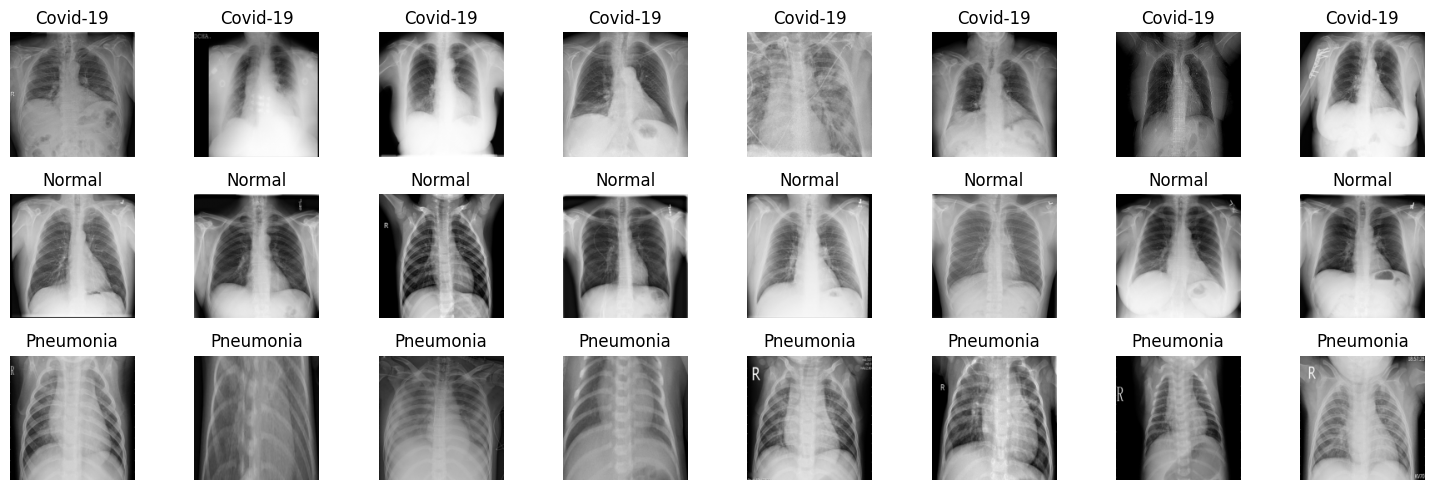

In [8]:
def visualize_images(Data, Target, classes, num_images=8):
    """
    Visualizes random samples from each class.
    
    Parameters:
    - data: List of preprocessed image arrays.
    - target: List of corresponding labels.
    - classes: List of unique class names to display.
    - num_images: Number of images to display per class.
    """
    # data and target converted to np array
    data_np = np.array(Data)
    target_np = np.array(Target)
    
    plt.figure(figsize=(15, 5))
    
    for class_idx, class_name in enumerate(classes):
        # images of current class
        class_images = data_np[target_np == class_name]
        
        # random selection of images 
        selected_images = class_images[np.random.choice(len(class_images), num_images, replace=False)]
        
        for i in range(num_images):
            plt.subplot(len(classes), num_images, class_idx * num_images + i + 1)
            plt.imshow(selected_images[i])
            plt.title(f"{class_name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

classes = ['Covid-19', 'Normal', 'Pneumonia']

visualize_images(Data, Target, classes, num_images=8)

###  Label Encoding 

Label encoding converts categorical labels (e.g 'Normal', 'Covid-19', 'Pneumonia') to numbers (e.g. 0, 1, 2). Categorical labels that are converted into integers make the data simpler to handle and process, reducing the complexity of computations. 

#### One-Hot Encoding

This project involves classifying x-ray images into three categories: 'Covid-19', 'Normal' and 'Pneumonia'. This is a multi-classification problem where the model should differentiate between three independent categories. One-hot encoding will ensure that each category is represented independently, making it easier for the model to treat each class as a seperate outcome. 

Additionally, this project uses Keras (a deep learning library) to train a neural network that can classify cxr images. Neural networks expect the target labels for multi-class problems such as this to be in a one-hot encoded format. 

Let's say our three classes are encoded as: 

'Covid-19' = 0
'Normal' = 1
'Pneumonia' = 2

With one-hot encoding, these labels would be converted into binary vectors: 

0 ('Covid-19') → [1, 0, 0]
1 ('Normal') → [0, 1, 0]
2 ('Pneumonia') → [0, 0, 1]

In these case of cxr classification, the classes 'Covid-19', 'Normal', and 'Pnuemonia' are categorically different without any inherent order. 

One-hot encoding removes this problem by representing each class as a separate binary vector, ensuring that the model does not assume any ordinal relationship between them. 

In [10]:
le = LabelEncoder()

encoded_labels = le.fit_transform(Target)

# integer labels into one-hot encoded vectors
one_hot_labels = to_categorical(encoded_labels)

print(f"Classes: {le.classes_}")
print(f"Example of encoded label: {encoded_labels[0]} -> {one_hot_labels[0]}")


Classes: ['Covid-19' 'Normal' 'Pneumonia']
Example of encoded label: 1 -> [0. 1. 0.]


### Splitting the Data 

Splitting the data will involve a first split and a second split. 

- First split: Splits the dataset into 80% training (X_train, y_train) and 20% testing (X_test, y_test). 

- Second split: Further splits the 80% training and 20% validation, resulting in; 64% training (X_train, y_train), 16% validation (X_val, y_val), and 20% testing (X_test, y_test). 


In [7]:
X = np.array(Data)
y = one_hot_labels

# First split: 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=encoded_labels  #ensures that the class distribution remains balanced
)

# Second split: 80% of the training set for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2,  # 20% of the 80% training set -> 16% of the total data
    random_state=42, 
    stratify=y_train  
)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (9697, 150, 150, 3)
Validation data shape: (2425, 150, 150, 3)
Testing data shape: (3031, 150, 150, 3)
Training labels shape: (9697, 3)
Validation labels shape: (2425, 3)
Testing labels shape: (3031, 3)


### Building and compiling the model

The idea here is to create a simple convolutional neural network (CNN) for image classification. CNN is a type of deep learning model specifically designed for analyzing visual data, like images. 

How does this work? CNNs are structured in the way that helps it detect patterns in images, like edges, shapes, textures and more complex details. CNNs are really good at understanding the spatial structure in images - meaning, they understand the layout of pixels in a way that helps with tasks like image classfication. 

A convolutional layer is the key building block in a CNN. It works by applying small filters over the image to scan for specific patters. 

The idea is to detect these basic features like edges, textures and shapes, which can later be combined to recognize more complex objects, like abnormalities in a cxr. By stacking multiple convolutional layers, a CNN can detect more complex and abstract features.

The patterns detected by convolutional layers wil help the CNN learn to classify images correctly. In this context, the CNN learns to identify patterns in chest X-rays that are characteristic of Normal, Covid-19, and Pneumonia cases.

#### Walkthrough of How This Model Works

- **Input Image:** The model takes in an image as input, typically resized to a standard size (e.g., 150x150 pixels).
- **Convulation Layers:** Apply filters to the image to detect basic features like edges, shapes, and textures. Each layer captures more complex features as the model goes deeper.
- **Pooling Layers:** Reduce the size of the image data (e.g., by taking the max value from small areas) to make the model faster and prevent overfitting.
- **Dropout Layers:** Randomly ignore some neurons during training to make the model more robust and prevent overfitting.
- **Flattening:** Converts the 2D data (e.g., image with width, height, and channels) into a 1D vector to be used in the next layers.
- Dense Layers: Combine the detected features in complex ways to learn higher-level representations of the data.
- **Training:** The model learns by adjusting its parameters over multiple learning rounds or epochs using the training data and checks its progress using the validation data.
- **Evaluation:** After training, the model is tested on unseen data to measure its performance and ensure it can generalize to new images.


In [8]:
# Defining the model
s = 150 

model = Sequential()


# Feature Extraction Layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(s, s, 3), kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Dropout(0.25))

# Dense Layers 
model.add(Flatten())  # 
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

# Compiling the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# Training the model with validation data
epochs = 25
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=40, verbose=1, validation_data=(X_val, y_val))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.7671 - loss: 1.0300 - val_accuracy: 0.8730 - val_loss: 0.3168
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8937 - loss: 0.2695 - val_accuracy: 0.9146 - val_loss: 0.2191
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.9328 - loss: 0.1781 - val_accuracy: 0.9278 - val_loss: 0.1957
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.9556 - loss: 0.1274 - val_accuracy: 0.9419 - val_loss: 0.1853
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.9660 - loss: 0.0980 - val_accuracy: 0.9439 - val_loss: 0.1711
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.9731 - loss: 0.0783 - val_accuracy: 0.9402 - val_loss: 0.1863
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.9790 - loss: 0.0541 - val_accuracy: 0.9427 - val_loss: 0.1705
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.9819 - loss: 0.0469 - val_accu

###  Evaluating the model

Evaluating the model is an important step in understanding how well it performed during training and validation. 

###  Plotting training and validation curves

###  Training and validation accuracy plot 

- How does the model's accuracy change over each epoch for both the training and the validation set?
- Helps you if the model's learning is improvig over time or if it is overfitting (when training accuracy is high, but validation accuracy stagnates or decreases).

###  Training and validation loss plot
- How does the model's loss (a measure of error) change over each epoch for both the training set and the validation set?
- Helps identify overfitting or underfitting (when the model struggles to learn).

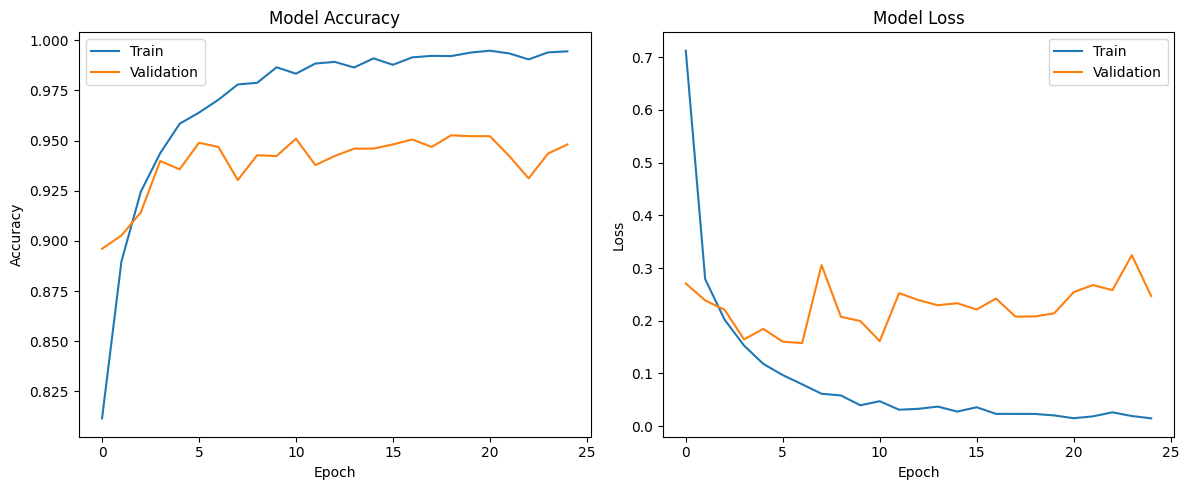

In [23]:
# Training and validation accuracy plot 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Training and validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

###  Model accuracy 

- Both training and validation accuracy increase rapidly during the initial epochs, indicating that the model is learning the patterns in the data.
- The training accuracy continues to improve and approaches 1.0 (100% accuracy), suggesting that the model is learning the training data very well.
- The validation accuracy reaches a peak and then fluctuates, stabilizing at a lower level than the training accuracy.
- The gap between training and validation accuracy suggests that the model may be overfitting. This means it performs well on the training data but not as well on unseen validation data.

###  Model loss
- Both training and validation loss decrease significantly in the early epochs, which is a good sign that the model is learning.
- The training loss continues to decrease, approaching a very low value, indicating that the model is fitting the training data very well.
- The validation loss shows fluctuations and does not decrease consistently; it even increases at certain points, which further suggests overfitting.
- A steadily decreasing training loss but an inconsistent validation loss that does not follow the same trend is another indication of overfitting.

###  Model performance
This model has likely overfit the training data. It learns the training set very well (high training accuracy and low training loss) but struggles to perform as well on validation data.


### Confusion Matrix 

Shows the number of correct and incorrect predictions for each class.

In [27]:
# Predicting classes on the test set
predictions = model.predict(X_test)

# Converting one-hot encoded predictions to single-label format 
y_pred_classes = np.argmax(predictions, axis=1) # Predicted labels
y_true_classes = np.argmax(testY, axis=1) # True labels 

# Generate confusion matrix report 
cm = confusion_matrix(y_true_classes, y_pred_classes)

print(cm)

95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 232ms/step
[[ 663   58    2]
 [  52 1981    6]
 [   5   17  247]]


In [30]:
class_names = le.classes_

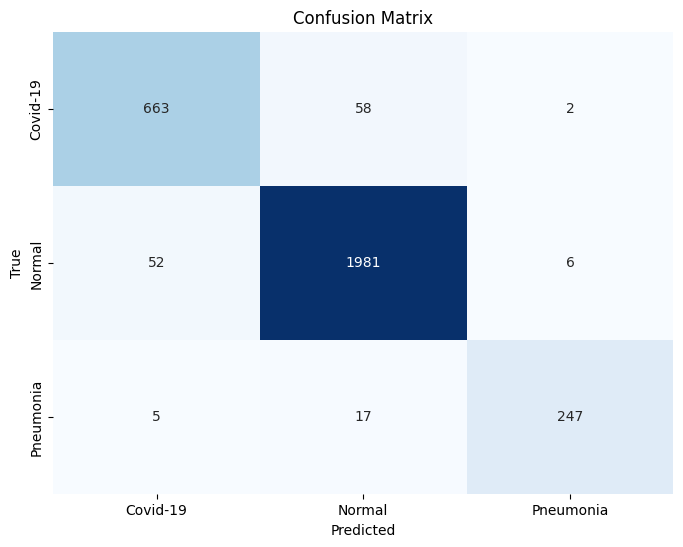

In [31]:
# Creating a dataFrame for the confusion matrix
Confusion_Matrix = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plotting the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_Matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

###   Explanation of the Matrix Values:
Top Left (663):

- The number of correctly predicted Covid-19 cases.
- This means the model accurately classified 663 images as Covid-19.
  
Top Middle (58):

- The number of Covid-19 cases that were incorrectly classified as Normal.
- Indicates 58 images of Covid-19 were misclassified as Normal.

Top Right (2):

- The number of Covid-19 cases that were incorrectly classified as Pneumonia.
- Shows that 2 Covid-19 images were wrongly labeled as Pneumonia.

Middle Left (52):

- The number of Normal images incorrectly classified as Covid-19.
- Indicates 52 images of Normal were labeled as Covid-19.

Middle Center (1981):

- The number of correctly classified Normal images.
- The model correctly labeled 1981 images as Normal.

Middle Right (6):

- The number of Normal images that were#  incorrectly classified as Pneumonia.
- Shows that 6 images of Normal were misclassified as Pneumonia.

Bottom Left (5):

- The number of Pneumonia images misclassified as Covid-19.
- 5 Pneumonia images were predicted as Covid-19.

Bottom Middle (17):

- The number of Pneumonia images misclassified as Normal.
- 17 Pneumonia images were labeled as Normal.

Bottom Right (247):

- The number of correctly classified Pneumonia cases.
- The model accurately classified 247 images as Pneumonia.

###  Classification report 

A classification report will provide detailed metrics for each class in the model and helps understand the model's performance in the more comprehensive way. 

In [32]:
# predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(y_true, y_pred, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.92083   0.91701   0.91892       723
      Normal    0.96352   0.97155   0.96752      2039
   Pneumonia    0.96863   0.91822   0.94275       269

    accuracy                        0.95381      3031
   macro avg    0.95099   0.93559   0.94306      3031
weighted avg    0.95379   0.95381   0.95373      3031



###  Metrics Explained 

- Precision: How many of the positive predictions were correct. High precision means fewer false positives.
- Recall: How many actual positives were correctly predicted. High recall means fewer false negatives.
- F1-Score: The balance between precision and recall (useful for imbalanced data). Higher scores mean better performance.
- Support: The number of true instances for each class (how many actual cases there were).

###  Overall Averages:

- Accuracy: 0.95381 – Overall, the model correctly classified 95.38% of all test samples.
- Macro avg: Average of precision, recall, and F1-score equally for each class.
- Weighted avg: Takes into account the support (number of instances) for each class, giving a balanced view of the model’s performance.